In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from itertools import cycle
import joblib  # To save the trained model

###  Load and Preprocess Dataset

In [2]:

# Load Dataset
base_dir = r"D:\Project\rice_leaf_diseases"
categories = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]


In [3]:
image_data = []
labels = []

for category in categories:
    folder_path = os.path.join(base_dir, category)
    label = categories.index(category)

    if not os.path.exists(folder_path):
        print(f" Folder not found: {folder_path}")
        continue
        
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            img = cv2.resize(img, (28, 28))  # Resize to 28x28 pixels
            img = img.flatten()  # Convert to 1D array
            img = img / 255.0  # Normalize pixel values (0-1)
            image_data.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error processing image {img_name}: {e}")

In [4]:
#Converting Data to NumPy Arrays

image_data = np.array(image_data, dtype="float32")
labels = np.array(labels, dtype="int")
print(f"Image data shape: {image_data.shape}")
print(f"Labels shape: {labels.shape}")


Image data shape: (120, 784)
Labels shape: (120,)


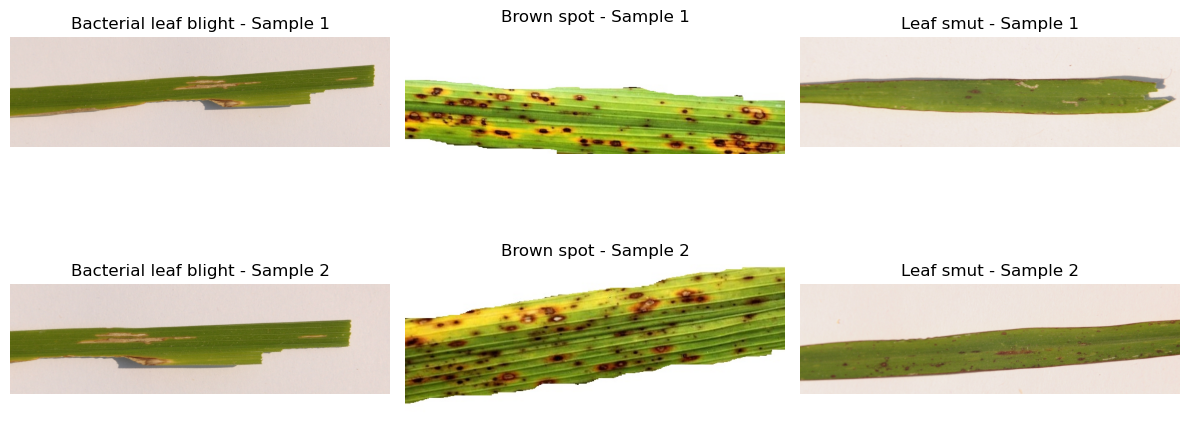

In [5]:
#Visualizing Sample Images from Each Category


plt.figure(figsize=(12, 6))

for col, category in enumerate(categories):
    folder_path = os.path.join(base_dir, category)
    img_names = os.listdir(folder_path)

    for row in range(2):  # 2 images per category
        img_path = os.path.join(folder_path, img_names[row])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 3, row * 3 + col + 1)  # 2 rows x 3 columns
        plt.imshow(img)
        plt.title(f"{category} - Sample {row + 1}")
        plt.axis("off")

plt.tight_layout()
plt.show()


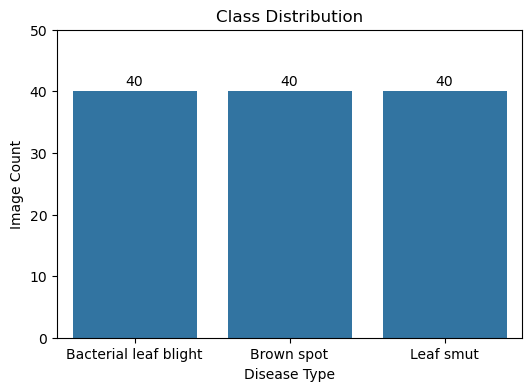

In [6]:
#Visualizing Class Distribution in Dataset

plt.figure(figsize=(6, 4))
ax = sns.countplot(x=labels)

plt.xticks([0, 1, 2], categories)
plt.title("Class Distribution")
plt.xlabel("Disease Type")
plt.ylabel("Image Count")
plt.ylim(0, 50)

for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            int(bar.get_height()),
            ha='center')

plt.show()


In [7]:
# Splitting the Dataset into Training, Validation, and Test Sets

X_train, X_temp, y_train, y_temp = train_test_split(image_data, labels, test_size=0.35, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.35, random_state=42)

print(f"Training Data: {X_train.shape}")
print(f"Validation Data: {X_val.shape}")
print(f"Test Data: {X_test.shape}")


Training Data: (78, 784)
Validation Data: (27, 784)
Test Data: (15, 784)


In [8]:

# Train SVM Model with GridSearchCV
svm_params = {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(random_state=42), svm_params, cv=10)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train Final SVM Model with best parameters
svm_model = SVC(kernel=best_params["kernel"], C=best_params["C"], probability=True, random_state=49)
svm_model.fit(X_train, y_train)

# Evaluate Model
y_pred = svm_model.predict(X_test)
svm_accuracy = metrics.accuracy_score(y_test, y_pred)
svm_acc = round(svm_accuracy * 100, 2)
print(f"SVM Model Accuracy: {svm_acc}%")

# Store in dictionary
accuracy_dict = {}
accuracy_dict["SVM"] = svm_acc


Best Parameters: {'C': 0.1, 'kernel': 'linear'}
SVM Model Accuracy: 86.67%


Train Accuracy: 84.61538461538461
Test Accuracy : 86.66666666666667

Confusion Matrix:
 [[7 0 1]
 [0 2 0]
 [0 1 4]]

Classification Report:
                        precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.88      0.93         8
           Brown spot       0.67      1.00      0.80         2
            Leaf smut       0.80      0.80      0.80         5

             accuracy                           0.87        15
            macro avg       0.82      0.89      0.84        15
         weighted avg       0.89      0.87      0.87        15



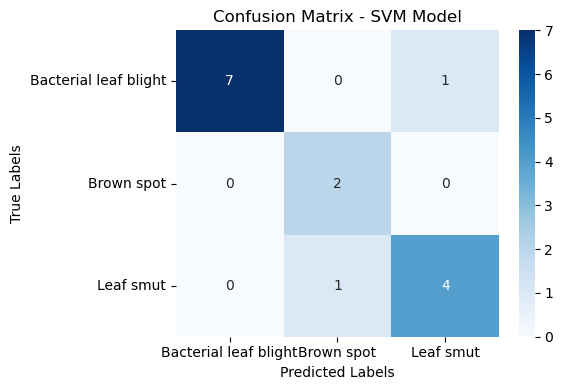

In [9]:
# SVM Model Evaluation Metrics and Visualization

print("Train Accuracy:", svm_model.score(X_train, y_train)*100)
print("Test Accuracy :", svm_model.score(X_test, y_test)*100)

y_pred = svm_model.predict(X_test)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=categories))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM Model")
plt.tight_layout()
plt.show()


### Decision Tree Classifier

In [10]:

# Train Decision Tree Model with GridSearchCV
dt_params = {'criterion': ['entropy'], 'max_depth': [2, 5, 6, 10, 15, 20, 30]}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=10)
dt_grid_search.fit(X_train, y_train)

best_dt_params = dt_grid_search.best_params_
print(f"Best Parameters for Decision Tree: {best_dt_params}")

# Train Final Decision Tree Model with best parameters
dt_model = DecisionTreeClassifier(criterion=best_dt_params["criterion"],
                                  max_depth=best_dt_params["max_depth"],
                                  random_state=42)
dt_model.fit(X_train, y_train)

# Train/Test Accuracy
train_accuracy = metrics.accuracy_score(y_train, dt_model.predict(X_train)) * 100
test_accuracy = metrics.accuracy_score(y_test, dt_model.predict(X_test)) * 100
dt_acc = round(test_accuracy, 2)

print(f"Decision Tree Model Accuracy     : {test_accuracy:.2f}%")

# Store Accuracy in Dictionary
accuracy_dict["Decision Tree"] = dt_acc


Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 5}
Decision Tree Model Accuracy     : 60.00%


Training Accuracy : 100.00%
Test Accuracy     : 60.00%

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.25      0.50      0.33         2
           2       0.75      0.60      0.67         5

    accuracy                           0.60        15
   macro avg       0.57      0.58      0.56        15
weighted avg       0.66      0.60      0.62        15



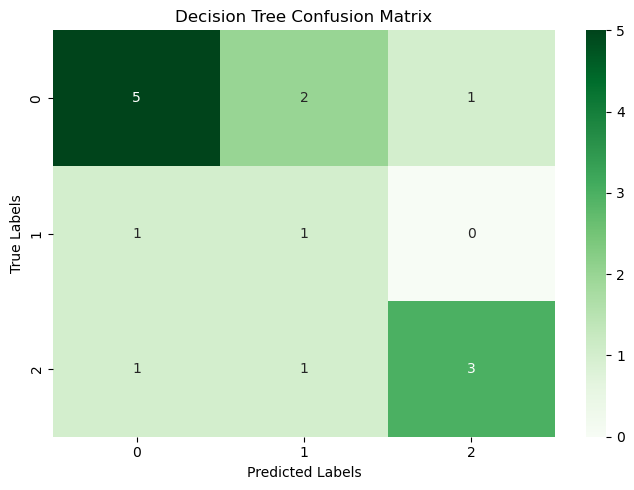

In [11]:
#  Model Evaluation Metrics and Visualization

print(f"Training Accuracy : {train_accuracy:.2f}%")
print(f"Test Accuracy     : {test_accuracy:.2f}%")

dt_pred = dt_model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, dt_pred))

conf_matrix = confusion_matrix(y_test, dt_pred)

# Confusion Matrix Plot using Seaborn
plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [12]:


# Train Random Forest with GridSearchCV
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20, 30, None],
    'criterion': ['entropy']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=10)
grid_search.fit(X_train, y_train)

best_rf_params = grid_search.best_params_
print(f"Best Parameters: {best_rf_params}")

# Train Final Random Forest Model with best parameters
rf_model = RandomForestClassifier(n_estimators=best_rf_params['n_estimators'],
                                  max_depth=best_rf_params['max_depth'],
                                  criterion=best_rf_params['criterion'],
                                  random_state=42)
rf_model.fit(X_train, y_train)

# Train/Test Accuracy
train_accuracy = metrics.accuracy_score(y_train, rf_model.predict(X_train)) * 100
test_accuracy = metrics.accuracy_score(y_test, rf_model.predict(X_test)) * 100
rf_acc = round(test_accuracy, 2)

print(f"Random Forest Model Accuracy     : {test_accuracy:.2f}%")

# Store Accuracy in Dictionary
accuracy_dict["Random Forest"] = rf_acc


Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100}
Random Forest Model Accuracy     : 73.33%


Train Accuracy: 100.00%
Test Accuracy : 73.33%

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.62      0.77         8
           Brown spot       0.50      1.00      0.67         2
            Leaf smut       0.67      0.80      0.73         5

             accuracy                           0.73        15
            macro avg       0.72      0.81      0.72        15
         weighted avg       0.82      0.73      0.74        15



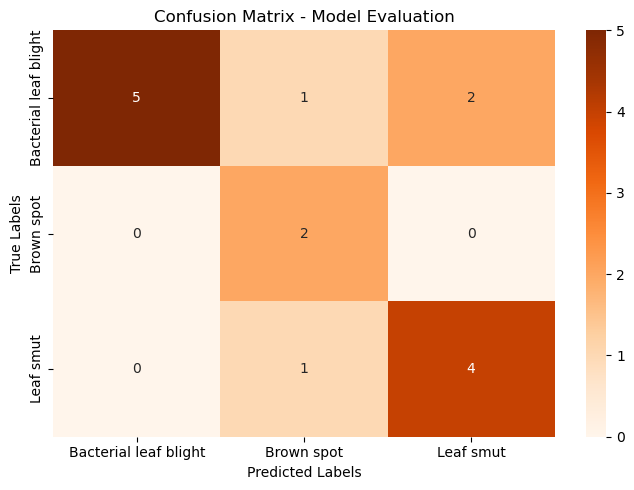

In [13]:
#  Model Evaluation Metrics and Visualization

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy : {test_accuracy:.2f}%")
y_pred =rf_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=categories, yticklabels=categories)

plt.title("Confusion Matrix - Model Evaluation")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


C:\Users\Arunkumar\AppData\Local\Temp\ipykernel_18332\4087456448.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=model_accuracies, palette=sns.color_palette("viridis", len(model_names)))


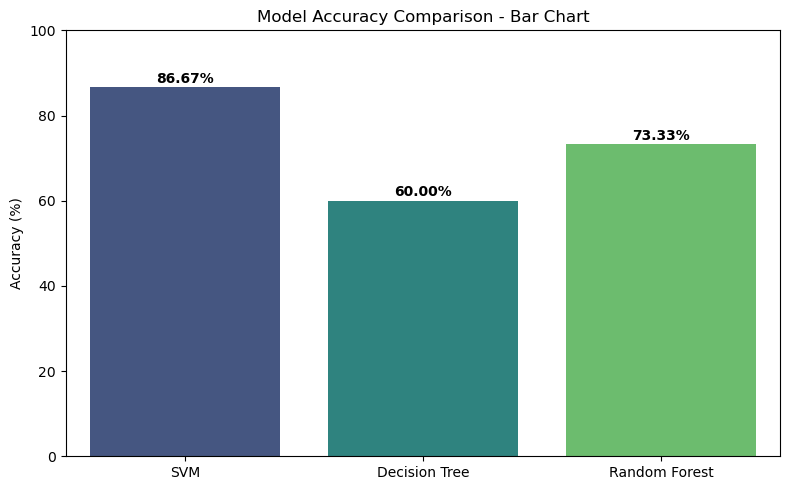

In [14]:
# Model Accuracy Comparison - Bar Chart

import warnings
model_names = ['SVM', 'Decision Tree', 'Random Forest']
model_accuracies = [svm_acc, dt_acc, rf_acc]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=model_accuracies, palette=sns.color_palette("viridis", len(model_names)))
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison - Bar Chart")

for index, value in enumerate(model_accuracies):
    plt.text(index, value + 1, f"{value:.2f}%", ha='center', fontweight='bold')

plt.ylim(0, 100)
plt.tight_layout()
plt.show()


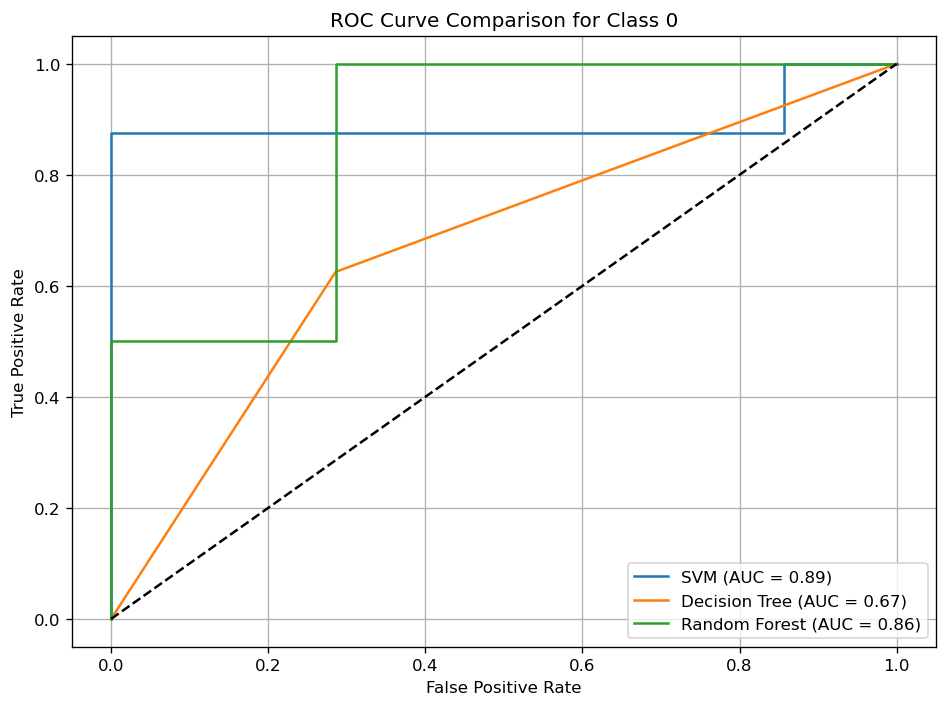

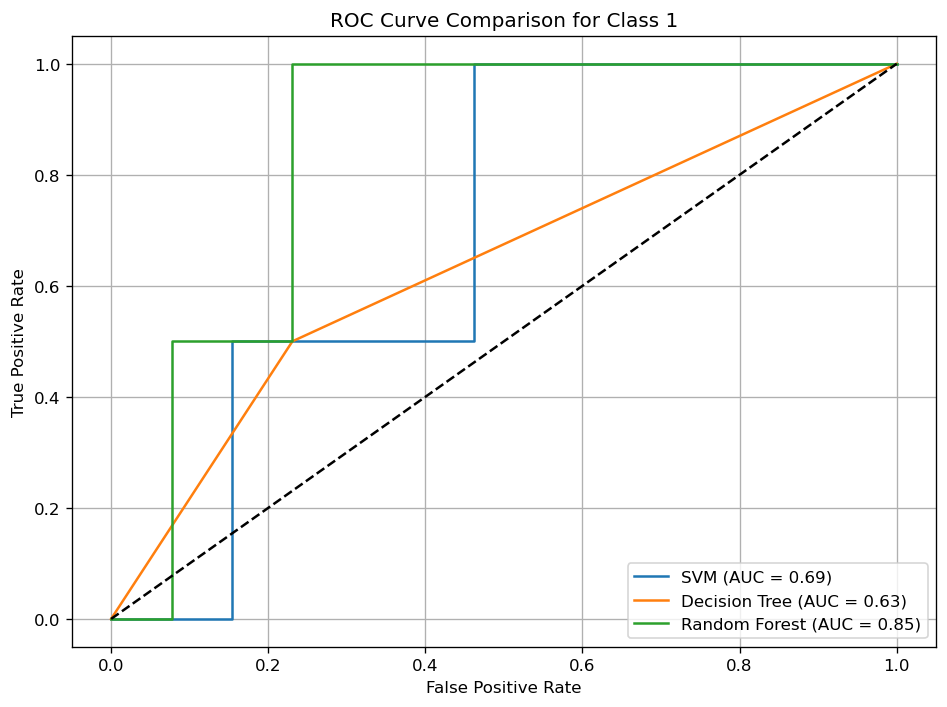

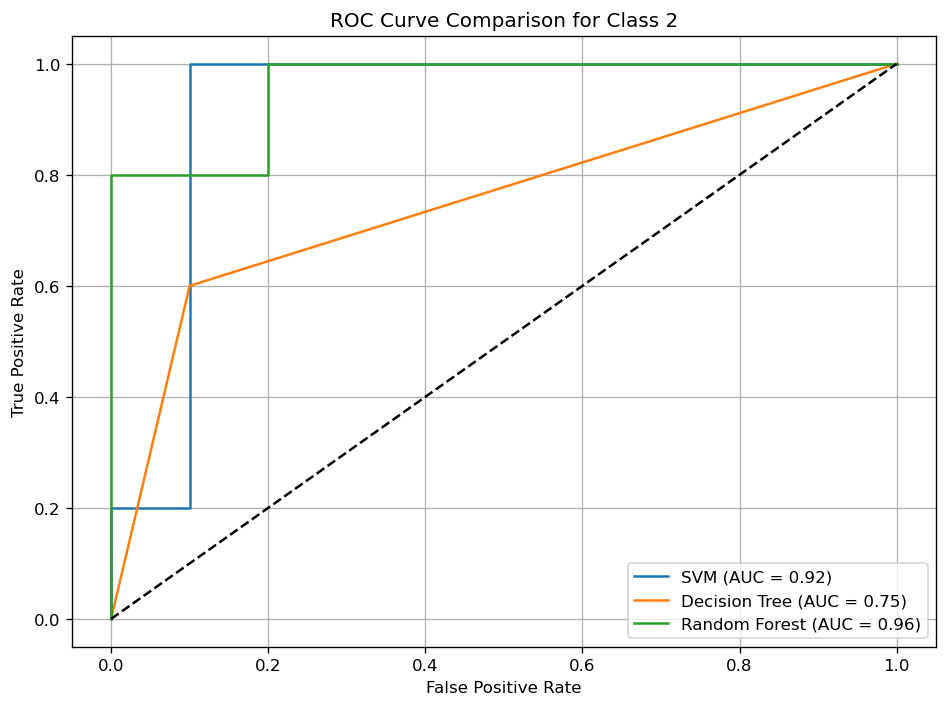

In [15]:

#ROC Curve and AUC Score Comparison for SVM, Decision Tree, and Random Forest Models

# Binarize test labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
svm_proba = svm_model.predict_proba(X_test)
dt_proba = dt_model.predict_proba(X_test)
rf_proba = rf_model.predict_proba(X_test)

# Initialize dictionary to store FPR, TPR, AUC for each model
roc_data = {
    'SVM': {'fpr': {}, 'tpr': {}, 'auc': {}},
    'Decision Tree': {'fpr': {}, 'tpr': {}, 'auc': {}},
    'Random Forest': {'fpr': {}, 'tpr': {}, 'auc': {}}
}

# Calculate FPR, TPR, AUC for each class and model
for i in range(n_classes):
    # SVM
    roc_data['SVM']['fpr'][i], roc_data['SVM']['tpr'][i], _ = roc_curve(y_test_bin[:, i], svm_proba[:, i])
    roc_data['SVM']['auc'][i] = auc(roc_data['SVM']['fpr'][i], roc_data['SVM']['tpr'][i])
    
    # Decision Tree
    roc_data['Decision Tree']['fpr'][i], roc_data['Decision Tree']['tpr'][i], _ = roc_curve(y_test_bin[:, i], dt_proba[:, i])
    roc_data['Decision Tree']['auc'][i] = auc(roc_data['Decision Tree']['fpr'][i], roc_data['Decision Tree']['tpr'][i])
    
    # Random Forest
    roc_data['Random Forest']['fpr'][i], roc_data['Random Forest']['tpr'][i], _ = roc_curve(y_test_bin[:, i], rf_proba[:, i])
    roc_data['Random Forest']['auc'][i] = auc(roc_data['Random Forest']['fpr'][i], roc_data['Random Forest']['tpr'][i])

# Plot ROC Curves
colors = cycle(['blue', 'red', 'green'])

for i in range(n_classes):
    plt.figure(figsize=(8, 6), dpi=120)
    for model, color in zip(roc_data.keys(), colors):
        plt.plot(
            roc_data[model]['fpr'][i],
            roc_data[model]['tpr'][i],
            label=f'{model} (AUC = {roc_data[model]["auc"][i]:.2f})'
        )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve Comparison for Class {i}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()


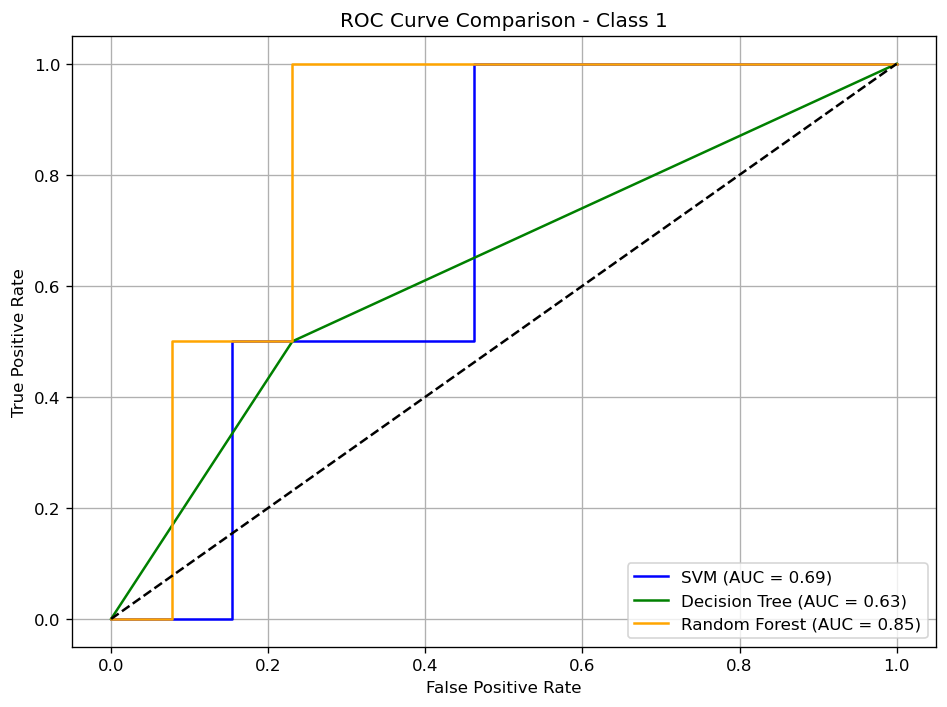

In [16]:
# ROC Curve & AUC Comparison for Selected Class (Class-wise Model Performance Analysis)

# Binarize y_test
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Get predicted probabilities
svm_proba = svm_model.predict_proba(X_test)
dt_proba = dt_model.predict_proba(X_test)
rf_proba = rf_model.predict_proba(X_test)

# Choose best class manually (change index here if needed) 
best_class = 1  

# Compute FPR, TPR, AUC for best class
fpr_svm, tpr_svm, _ = roc_curve(y_test_bin[:, best_class], svm_proba[:, best_class])
auc_svm = auc(fpr_svm, tpr_svm)

fpr_dt, tpr_dt, _ = roc_curve(y_test_bin[:, best_class], dt_proba[:, best_class])
auc_dt = auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_test_bin[:, best_class], rf_proba[:, best_class])
auc_rf = auc(fpr_rf, tpr_rf)

# Plot Comparison 
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})', color='blue')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})', color='green')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='orange')

plt.plot([0, 1], [0, 1], 'k--')
plt.title(f'ROC Curve Comparison - Class {best_class}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()
